Load Data

In [ ]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations

df = pd.read_csv('/content/drive/MyDrive/ML_Data/human_suicide_risks.csv', sep=',')

print(df.shape)
df.head()

Mounted at /content/drive
(500, 8)


,ID,Gender,Mental_Health_Issue,Substance_Abuse,Previous_Attempts,Abuse History,Social Isolation,Financial Problem
0,1,Male,No,No,Yes,No,Yes,Yes
1,2,Male,Yes,Yes,No,No,No,No
2,3,Female,Yes,Yes,No,Yes,Yes,Yes
3,4,Male,Yes,Yes,Yes,No,No,Yes
4,5,Female,Yes,Yes,No,Yes,Yes,Yes


# Step 1: Prepare transactions

>



In [ ]:
def prepare_transactions(data, columns):
    transactions = []
    for _, row in data.iterrows():
        transaction = [col for col in columns if row[col] == 'Yes']
        transactions.append(transaction)
    return transactions

selected_columns = ['Mental_Health_Issue', 'Substance_Abuse', 'Previous_Attempts',
                    'Abuse History', 'Social Isolation', 'Financial Problem']
transactions = prepare_transactions(df, selected_columns)


# Step 2: Apriori Algorithm


In [ ]:
def apriori_analysis(transactions, min_support):
    C1 = {}
    for transaction in transactions:
        for item in transaction:
            C1[item] = C1.get(item, 0) + 1

    L1 = {key: value for key, value in C1.items() if value / len(transactions) >= min_support}

    L = [L1]
    k = 2
    while L[k - 2]:
        Ck = {}
        for transaction in transactions:
            for combo in combinations(transaction, k):
                Ck[combo] = Ck.get(combo, 0) + 1

        Lk = {key: value for key, value in Ck.items() if value / len(transactions) >= min_support}
        L.append(Lk)
        k += 1

    frequent_itemsets = [item for sublist in L for item in sublist.keys()]
    return frequent_itemsets

# Step 3: Generate Association Rules


In [ ]:
def generate_association_rules(frequent_itemsets, transactions, min_confidence):
    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) > 1:
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    consequent = tuple(set(itemset) - set(antecedent))
                    antecedent_support = sum(1 for transaction in transactions if set(antecedent).issubset(transaction))
                    both_support = sum(1 for transaction in transactions if set(itemset).issubset(transaction))
                    if antecedent_support > 0:
                        confidence = both_support / antecedent_support
                        if confidence >= min_confidence:
                            rules.append((antecedent, consequent, confidence))
    return rules

# Step 4: Visualization Functions


In [ ]:
def plot_network_graph(rules):
    G = nx.DiGraph()
    for antecedent, consequent, confidence in rules:
        G.add_edge(', '.join(antecedent), ', '.join(consequent), weight=confidence)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
            font_size=10, font_weight='bold', arrowsize=20)
    plt.title('Association Rules Network')
    plt.show()

def plot_heatmap(rules):
    rule_data = pd.DataFrame(rules, columns=['Antecedent', 'Consequent', 'Confidence'])
    pivot_table = rule_data.pivot_table(index='Antecedent', columns='Consequent', values='Confidence', fill_value=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
    plt.title('Heatmap of Association Rules')
    plt.show()


# Example Execution

In [ ]:
min_support = 0.25
min_confidence = 0.5
frequent_itemsets = apriori_analysis(transactions, min_support)
rules = generate_association_rules(frequent_itemsets, transactions, min_confidence)

print("Frequent Itemsets:", frequent_itemsets)
print("Association Rules:")
for antecedent, consequent, confidence in rules:
    print(f"{antecedent} => {consequent} (Confidence: {confidence:.2f})")

Frequent Itemsets: ['Previous_Attempts', 'Social Isolation', 'Financial Problem', 'Mental_Health_Issue', 'Substance_Abuse', 'Abuse History', ('Previous_Attempts', 'Social Isolation'), ('Previous_Attempts', 'Financial Problem'), ('Social Isolation', 'Financial Problem'), ('Mental_Health_Issue', 'Substance_Abuse'), ('Substance_Abuse', 'Abuse History'), ('Substance_Abuse', 'Social Isolation'), ('Substance_Abuse', 'Financial Problem'), ('Abuse History', 'Social Isolation'), ('Abuse History', 'Financial Problem'), ('Substance_Abuse', 'Previous_Attempts'), ('Previous_Attempts', 'Abuse History')]
Association Rules:
('Previous_Attempts',) => ('Social Isolation',) (Confidence: 0.54)
('Social Isolation',) => ('Previous_Attempts',) (Confidence: 0.56)
('Previous_Attempts',) => ('Financial Problem',) (Confidence: 0.51)
('Financial Problem',) => ('Previous_Attempts',) (Confidence: 0.50)
('Social Isolation',) => ('Financial Problem',) (Confidence: 0.52)
('Mental_Health_Issue',) => ('Substance_Abuse',

# Visualize the results


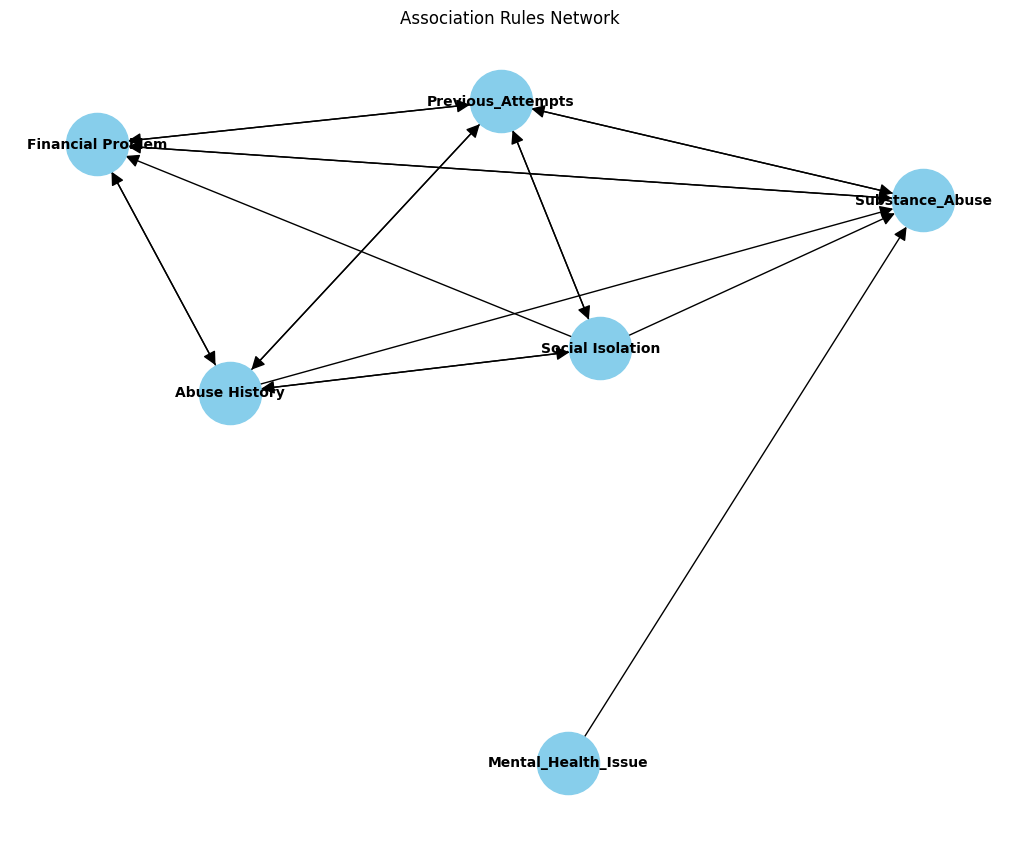

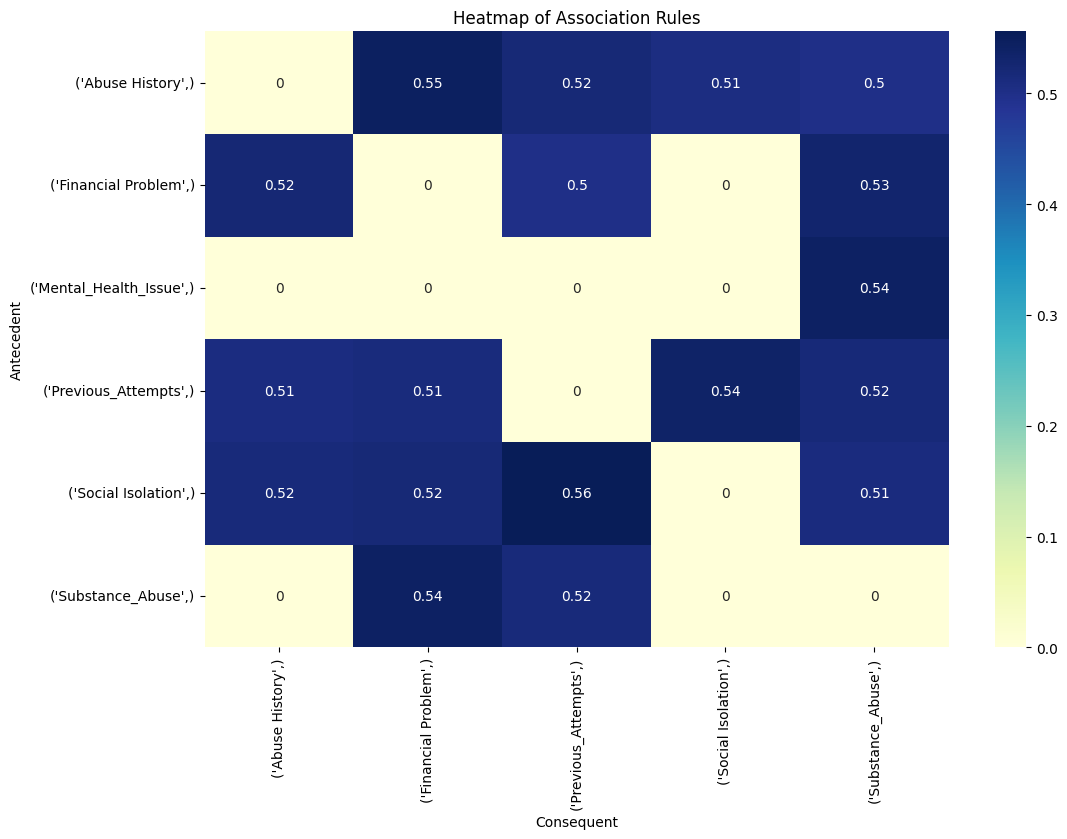

In [8]:
plot_network_graph(rules)
plot_heatmap(rules)
